# Leading the Charge: Predicting the Demand for Electric Vehicles and Chargers in Washington State

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

## Market at a Glance
Climate change, including concerns about rising greenhouse gas emissions, has become an increasingly pressing concern among officials in the United States and around the world over the past several years. According to the U.S. Environmental Protection Agency (EPA), "greenhouse gas (GHG) emissions from transportation account for about 29 percent of total U.S. greenhouse gas emissions, making it the largest contributor of U.S. GHG emissions."[¹](https://www.epa.gov/transportation-air-pollution-and-climate-change/carbon-pollution-transportation) In light of these findings and the research being conducted around this issue, President Joe Biden and his administration are working on passing a [bipartisan infrastructure deal](https://www.whitehouse.gov/briefing-room/statements-releases/2021/06/24/fact-sheet-president-biden-announces-support-for-the-bipartisan-infrastructure-framework/) that would prioritize clean energy and support the development of a nationwide network of electric vehicle chargers.

In addition to large scale policy proposals at the national level, some states are also taking action on their own. For example, both California and Washington are working towards mandating electric vehicles by 2035 and 2030 respectively in an effort to phase out vehicles that use gasoline. Furthermore, within the private sector, several major car manufacturers (such as Ford, GM, Volvo, etc.) have [announced](https://www.caranddriver.com/news/g35562831/ev-plans-automakers-timeline/) that they will be going fully electric in the next decade, which would prove to be a significant change in the auto industry. Taken together, if implemented, these changes in both the public and private sectors would cause a massive increase in demand for electric vehicles (EVs). The question is: how will the current charging infrastructure of these states support an influx in demand for new EVs? 

## Business Case
To be able to achieve a fully electric future and keep up with the demand for chargers, the charging infrastructure has to be expanded. Therefore, the Washington Department of Transportation is planning to spend $8 million on charging infrastructure projects between July 1st, 2021 and June 30, 2023[²](https://wsdot.wa.gov/business/innovative-partnerships/zero-emission-vehicle-infrastructure-partnerships). This is a great business opportunity for EV charging companies. By investing in Washington state, not only would these companies be eligible for government funding, but they would also put themselves in a profitable position as the demand for chargers continues to increase over the coming years. 

## Business Problem & Goal
In order to position electric vehicle chargers strategically, it is vital to model and predict the demand for electric vehicles in each county in Washington. In an effort to find counties that will have the most demand with the least amount of chargers, this analysis focuses on time series modeling of the amount of electric vehicles in the top 10 counties within Washington with the most purchases of new electric vehicles. Our goal is to recommend top 3 counties to invest in.

# OBTAIN

For our analysis we will be using the [electric vehicle title and registration activity data](https://data.wa.gov/Transportation/Electric-Vehicle-Title-and-Registration-Activity/rpr4-cgyd) provided by Washington state to calculate the amount of electric vehicles in each county over time. Additionally, in the Interpret section we will be looking at the [current charging infrastructure data](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/) provided by the National Renewable Energy Laboratory to find counties with the most potential for generating financial success. 

## Obtaining data from Washington State

### Accessing and Storing API Keys

In [321]:
#option to run API calls in the notebook
run_api_calls = False

In [322]:
if run_api_calls == True:    
    #defining a function to open/load json files
    import json

    def get_keys(path):
        """Function accesses and returns the json file at the specified path.
        -------------------------------
        Arguments:
        path : str, the file path belonging to the json file to be opened and 
        returned.
        """
        with open(path) as f:
            return json.load(f)

In [323]:
#storing api keys in variables
if run_api_calls == True:
    keys = get_keys("/Users/berke/.secret/socrata_api_project_5.json")

    api_key_socrata = keys['api_key']
    app_token_socrata = keys['app_token']
    api_key_secret_socrata = keys['api_key_secret']

### API Requests and Pagination

In [324]:
import requests
import time
import pandas as pd

if run_api_calls == True:
    #Defining/initializing API request headers and parameters
    headers = {'X-App-Token': app_token_socrata, 'username': api_key_socrata,
               'password': api_key_secret_socrata}
    params = {'$limit': '50000', '$offset': None}
    offset = list(range(0, 500000, 50000))

    #Requesting data from API and parsing results to a dictionary
    dfs = {}
    for number in offset:
        params['$offset'] = str(number)
        r = requests.get(f'https://data.wa.gov/resource/rpr4-cgyd.json?', 
                         headers=headers, params=params)
        dfs[f'df_{number}']=pd.DataFrame.from_records(r.json())
        time.sleep(1)

### Parsing results to a final compressed .csv file

In [325]:
if run_api_calls == True:
    #saving all pages as one csv file
    import os
    from datetime import date

    today = date.today().strftime("%m-%d-%Y")
    path = './data'
    output_file = os.path.join(path,f'title_transactions-{today}.csv.gz')

    for key, df in dfs.items():
        if key == 'df_0':
            df_final = dfs['df_0']
        else:
            df_final = pd.concat([df_final, df], axis=0)

    df_final.to_csv(output_file, index=False, compression='gzip')    

### Importing data

In [326]:
#importing the data back into the notebook
df=pd.read_csv('data/title_transactions-06-29-2021.csv.gz', compression='gzip', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433172 entries, 0 to 433171
Data columns (total 30 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   electric_vehicle_type                                    433172 non-null  object 
 1   vin_1_10                                                 433172 non-null  object 
 2   model_year                                               433172 non-null  int64  
 3   make                                                     433172 non-null  object 
 4   model                                                    433172 non-null  object 
 5   new_or_used_vehicle                                      433172 non-null  object 
 6   sale_price                                               433172 non-null  float64
 7   transaction_date                                         433172 non-null  object 
 8   transaction_type   

# SCRUB

## Feature Engineering

### Changing type of 'transaction_date' to datetime

Since we will be using the transaction_date column for the time series we are going to be creating, we need to change its type from object to datetime.

In [327]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_date,transaction_type,transaction_year,...,dol_vehicle_id,legislative_district,hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility,meets_2019_hb_2042_electric_range_requirement,meets_2019_hb_2042_sale_date_requirement,meets_2019_hb_2042_sale_price_value_requirement,odometer_reading,odometer_code,transportation_electrification_fee_paid,hybrid_vehicle_electrification_fee_paid
0,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,2017-01-31,Original Title,2017,...,348693390,48.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable
1,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,2017-03-22,Original Registration,2017,...,329748177,5.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No
2,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,2017-03-22,Original Title,2017,...,329748177,5.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable
3,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,2017-03-24,Original Registration,2017,...,242531271,10.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No
4,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,2017-03-24,Original Title,2017,...,242531271,10.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019,True,False,True,99,Actual Mileage,Not Applicable,Not Applicable


### Feature Engineering "m/y" column

We will be using the m/y information to clean duplicates in section 4.5.

In [328]:
df['m/y'] = df['transaction_date'].dt.strftime("%m-%Y")

### Adjusting the index of df

In [329]:
df.set_index('transaction_date', inplace=True)
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,transaction_year,electric_vehicle_fee_paid,...,legislative_district,hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility,meets_2019_hb_2042_electric_range_requirement,meets_2019_hb_2042_sale_date_requirement,meets_2019_hb_2042_sale_price_value_requirement,odometer_reading,odometer_code,transportation_electrification_fee_paid,hybrid_vehicle_electrification_fee_paid,m/y
transaction_date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,2017,Not Applicable,...,48.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,Original Registration,2017,No,...,5.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No,03-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,2017,Not Applicable,...,5.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,Original Registration,2017,No,...,10.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,2017,Not Applicable,...,10.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019,True,False,True,99,Actual Mileage,Not Applicable,Not Applicable,03-2017


## Column Exploration

There is great information in this dataframe but there seems to also be irrelevant information for our purposes. In order to clean up the dataframe we need to know which columns we should keep and which ones we should drop. 

### Dropping columns that are for Governmental Use

To start off, there are several columns that seem to be of use for the government or the vehicle's owner but is irrelevant for us in answering the business question at hand. Some examples include the following along with the description provided in the API:

**'meets_2019_hb_2042_electric_range_requirement':** True = The vehicle model can travel 30 miles or more solely on electricity. Otherwise, False.

**'meets_2019_hb_2042_sale_date_requirement':** True = The vehicle was sold on or after August 1, 2019. Otherwise, False.

**'meets_2019_hb_2042_sale_price_value_requirement':** True = The vehicle sale price/value was 45,000 or less for new vehicles, or 30,000 or less for used vehicles. Otherwise, False.

**'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility':** Shows if vehicle title transactions were eligible for the sales tax exemption authorized by House Bill 2042 during the 2019 Legislative Session. If not eligible, reasons are provided.

**'non_clean_alternative_fuel':** Shows if new vehicle title transactions were eligible for the sales tax exemption authorized by House Bill 2778 during the 2015 Legislative Session. If not eligible, reasons are provided.

**'transportation_electrification_fee_paid':** The Transportation Electrification Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction

**'hybrid_vehicle_electrification_fee_paid':** The Hybrid Vehicle Electrification Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction.

**'legislative_district':** The specific section of Washington State that the vehicle's owner resides in, as represented in the state legislature.

**'electric_vehicle_fee_paid':** The Electric Vehicle Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction.

We can go ahead and drop these columns since these are mostly about whether a fee was paid or if the vehicle met certain governmental requirements for tax credits or otherwise.

In [330]:
drop_cols = ['electric_vehicle_fee_paid',
             'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility',
             'meets_2019_hb_2042_electric_range_requirement', 
             'meets_2019_hb_2042_sale_date_requirement', 
             'meets_2019_hb_2042_sale_price_value_requirement', 
             'transportation_electrification_fee_paid', 
             'hybrid_vehicle_electrification_fee_paid', 'legislative_district', 
             'non_clean_alternative_fuel']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,transaction_year,county,...,zip,electric_range,base_msrp,date_of_vehicle_sale,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,2017,King,...,98039.0,200,0,2016-12-27T00:00:00.000,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,Original Registration,2017,King,...,98065.0,200,0,NaN,Passenger,WA,329748177,0,Odometer reading is not collected at time of r...,03-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,2017,King,...,98065.0,200,0,2017-03-03T00:00:00.000,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,Original Registration,2017,Island,...,98277.0,53,0,NaN,Passenger,WA,242531271,0,Odometer reading is not collected at time of r...,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,2017,Island,...,98277.0,53,0,2017-03-11T00:00:00.000,Passenger,WA,242531271,99,Actual Mileage,03-2017


### Dropping columns with redundant information

In [331]:
df['date_of_vehicle_sale'].isna().sum()

289770

Since we have the full transaction date in our index the 'transaction_year' column is redundant. Additionally, the date_of_vehicle_sale column seems to be missing quite a bit of information. Where there is data, the difference between the transaction date and the actual vehicle sale seems to be around a couple weeks so the difference is not meaningful for our purposes.

Also, we already have the sale price of the vehicle at the time of the transaction so the base MSRP column is irrelevant. So we can go ahead and drop these columns from our dataframe as well. We will be keeping the rest of the columns for the time being for EDA purposes.

In [332]:
drop_cols = ['transaction_year', 'base_msrp', 'date_of_vehicle_sale']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,King,MEDINA,98039.0,200,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,Original Registration,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,0,Odometer reading is not collected at time of r...,03-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,Original Registration,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,0,Odometer reading is not collected at time of r...,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,99,Actual Mileage,03-2017


We will not be using the registration information for this analysis and instead will be focusing on the title transactions to calculate the amount of electric vehicles on the road. Therefore we can filter out this information from our dataframe.

In [333]:
#filtering out registration information to keep vehicle purchase information
df=df[(df['transaction_type']=='Original Title') | 
      (df['transaction_type']=='Transfer Title')]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121542 entries, 2017-01-31 to 2017-05-01
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   electric_vehicle_type  121542 non-null  object 
 1   vin_1_10               121542 non-null  object 
 2   model_year             121542 non-null  int64  
 3   make                   121542 non-null  object 
 4   model                  121542 non-null  object 
 5   new_or_used_vehicle    121542 non-null  object 
 6   sale_price             121542 non-null  float64
 7   transaction_type       121542 non-null  object 
 8   county                 121534 non-null  object 
 9   city                   121514 non-null  object 
 10  zip                    121537 non-null  float64
 11  electric_range         121542 non-null  int64  
 12  vehicle_primary_use    121542 non-null  object 
 13  state_of_residence     121540 non-null  object 
 14  dol_vehicle_id      

## Addressing Duplicates

Now that we have a dataframe that shows only the purchases of new and used cars and none of the registration information, we can go ahead and address duplicates.

### Exact Duplicates

In [334]:
df[df.duplicated()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2018-04-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6S51J,2018,CHEVROLET,Volt,New,33108.0,Original Title,Snohomish,EDMONDS,98020.0,53,Passenger,WA,165661520,5,Actual Mileage,04-2018
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017
2019-01-02,Battery Electric Vehicle (BEV),5YJXCBE27J,2018,TESLA,Model X,New,114700.0,Original Title,King,SEATTLE,98102.0,238,Passenger,WA,116650978,50,Actual Mileage,01-2019
2019-04-05,Battery Electric Vehicle (BEV),5YJ3E1EA9K,2019,TESLA,Model 3,New,46200.0,Original Title,King,SEATTLE,98102.0,220,Passenger,WA,209719674,50,Actual Mileage,04-2019
2018-07-13,Battery Electric Vehicle (BEV),5YJ3E1EA5J,2018,TESLA,Model 3,New,57500.0,Original Title,Clark,CAMAS,98607.0,215,Passenger,WA,338187300,50,Actual Mileage,07-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-17,Battery Electric Vehicle (BEV),1N4AZ0CP5F,2015,NISSAN,Leaf,Used,9950.0,Original Title,King,KENMORE,98028.0,84,Passenger,WA,117975602,30068,Actual Mileage,01-2017
2017-01-13,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6E49D,2013,CHEVROLET,Volt,Used,0.0,Original Title,Kittitas,ELLENSBURG,98926.0,38,Passenger,WA,349914309,30899,Actual Mileage,01-2017
2017-03-08,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6E42D,2013,CHEVROLET,Volt,Used,13992.0,Transfer Title,Pierce,GRAHAM,98338.0,38,Passenger,WA,136639037,25903,Actual Mileage,03-2017


> We have 1287 rows of data that are duplicated. In order to make sure that these are indeed duplicates with no differences we will inspect a few of the vehicles below:

#### Inspecting Duplicates

In [335]:
df[df['dol_vehicle_id']==165661520]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2018-04-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6S51J,2018,CHEVROLET,Volt,New,33108.0,Original Title,Snohomish,EDMONDS,98020.0,53,Passenger,WA,165661520,5,Actual Mileage,04-2018
2018-04-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6S51J,2018,CHEVROLET,Volt,New,33108.0,Original Title,Snohomish,EDMONDS,98020.0,53,Passenger,WA,165661520,5,Actual Mileage,04-2018


In [336]:
df[df['dol_vehicle_id']==154225991]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017


Data in each column for these transactions seem to be exactly the same so we can go ahead and drop these rows.

In [337]:
df.drop_duplicates(inplace=True)
#verifying that duplicates have been removed
len(df[df.duplicated()])

0

In [338]:
df[df['dol_vehicle_id']==154225991]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017


### Duplicates by Date/ID/County

In [339]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id', 'county'], keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2018-12-10,Plug-in Hybrid Electric Vehicle (PHEV),WBY1Z4C57G,2016,BMW,i3,Used,19967.0,Transfer Title,King,RENTON,98057.0,72,Passenger,WA,46112,19433,Actual Mileage,12-2018
2018-12-10,Plug-in Hybrid Electric Vehicle (PHEV),WBY1Z4C57G,2016,BMW,i3,Used,19967.0,Transfer Title,King,KIRKLAND,98033.0,72,Passenger,WA,46112,19433,Actual Mileage,12-2018
2019-06-19,Battery Electric Vehicle (BEV),KNDJP3AEXG,2016,KIA,SOUL,Used,11000.0,Transfer Title,Benton,KENNEWICK,99336.0,93,Passenger,WA,110708,26166,Actual Mileage,06-2019
2019-06-19,Battery Electric Vehicle (BEV),KNDJP3AEXG,2016,KIA,SOUL,Used,11000.0,Transfer Title,Benton,RICHLAND,99352.0,93,Passenger,WA,110708,26166,Actual Mileage,06-2019
2019-09-26,Plug-in Hybrid Electric Vehicle (PHEV),1G1RC6S54H,2017,CHEVROLET,Volt,Used,18276.0,Transfer Title,Clark,VANCOUVER,98685.0,53,Passenger,WA,1069358,35710,Actual Mileage,09-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-09,Battery Electric Vehicle (BEV),5YJ3E1EB1K,2019,TESLA,Model 3,New,55190.0,Original Title,King,SEATTLE,98109.0,220,Passenger,WA,478846056,50,Actual Mileage,10-2019
2019-11-01,Battery Electric Vehicle (BEV),5YJ3E1EA4K,2019,TESLA,Model 3,Used,39100.0,Original Title,Pierce,SPANAWAY,98387.0,220,Passenger,WA,478854330,375,Actual Mileage,11-2019
2019-11-01,Battery Electric Vehicle (BEV),5YJ3E1EA4K,2019,TESLA,Model 3,Used,39100.0,Original Title,Pierce,TACOMA,98405.0,220,Passenger,WA,478854330,375,Actual Mileage,11-2019


The dataframe currently contains 7241 rows of duplicated data. In this case, there are duplications for the same cars since there is different city and zipcode information shown in the transactions. Otherwise the data is exactly the same. We will be keeping the last of each of the duplicated rows.

In [340]:
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id', 'county'], keep='last', 
                   inplace=True)

In [341]:
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,King,MEDINA,98039.0,200,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,99,Actual Mileage,03-2017
2017-02-15,Battery Electric Vehicle (BEV),KNDCB3LCXH,2017,KIA,Niro,New,22890.0,Original Title,King,KENT,98042.0,0,Passenger,WA,200890098,5,Actual Mileage,02-2017
2016-12-30,Battery Electric Vehicle (BEV),1N4BZ0CP2G,2016,NISSAN,Leaf,New,32500.0,Original Title,Snohomish,MILL CREEK,98012.0,84,Passenger,WA,117062585,16,Actual Mileage,12-2016


### Duplicates by Date/ID

In [342]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], 
                 keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-05-12,Plug-in Hybrid Electric Vehicle (PHEV),KNAGV4LDXH,2017,KIA,Optima,New,36395.0,Original Title,Walla Walla,WALLA WALLA,99362.0,29,Passenger,WA,1061763,20,Actual Mileage,05-2017
2017-05-12,Plug-in Hybrid Electric Vehicle (PHEV),KNAGV4LDXH,2017,KIA,Optima,New,36395.0,Original Title,Yakima,YAKIMA,98901.0,29,Passenger,WA,1061763,20,Actual Mileage,05-2017
2018-03-30,Plug-in Hybrid Electric Vehicle (PHEV),5UXKT0C59G,2016,BMW,X5,Used,38977.0,Transfer Title,King,BELLEVUE,98004.0,14,Passenger,WA,1121270,42505,Actual Mileage,03-2018
2018-03-30,Plug-in Hybrid Electric Vehicle (PHEV),5UXKT0C59G,2016,BMW,X5,Used,38977.0,Transfer Title,Whatcom,BLAINE,98230.0,14,Passenger,WA,1121270,42505,Actual Mileage,03-2018
2018-12-07,Battery Electric Vehicle (BEV),1N4AZ0CPXF,2015,NISSAN,Leaf,Used,11991.0,Transfer Title,King,BELLEVUE,98008.0,84,Passenger,WA,1155164,28482,Actual Mileage,12-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15,Battery Electric Vehicle (BEV),5YJ3E1EB4K,2019,TESLA,Model 3,New,56190.0,Original Title,Thurston,LACEY,98516.0,220,Passenger,WA,478598431,50,Actual Mileage,10-2019
2019-10-05,Battery Electric Vehicle (BEV),5YJ3E1EB5K,2019,TESLA,Model 3,New,56190.0,Original Title,Adams,OTHELLO,99344.0,220,Passenger,WA,478679400,50,Actual Mileage,10-2019
2019-10-05,Battery Electric Vehicle (BEV),5YJ3E1EB5K,2019,TESLA,Model 3,New,56190.0,Original Title,Benton,RICHLAND,99352.0,220,Passenger,WA,478679400,50,Actual Mileage,10-2019


Similar to the duplicates we removed in the prior section, we have duplicate transactions showing up for the same cars with exactly the same information except for the county, city and zipcode information. We will once again assume that the last transaction for each of these duplications is the accurate one, and keep it.

In [343]:
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id'], keep='last', inplace=True)

In [344]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114458 entries, 2017-01-31 to 2017-05-01
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   electric_vehicle_type  114458 non-null  object 
 1   vin_1_10               114458 non-null  object 
 2   model_year             114458 non-null  int64  
 3   make                   114458 non-null  object 
 4   model                  114458 non-null  object 
 5   new_or_used_vehicle    114458 non-null  object 
 6   sale_price             114458 non-null  float64
 7   transaction_type       114458 non-null  object 
 8   county                 114452 non-null  object 
 9   city                   114431 non-null  object 
 10  zip                    114453 non-null  float64
 11  electric_range         114458 non-null  int64  
 12  vehicle_primary_use    114458 non-null  object 
 13  state_of_residence     114456 non-null  object 
 14  dol_vehicle_id      

## Checking for and Addressing Null Values

Next, we will be checking for and addressing null values in the dataset.

In [346]:
df.isna().sum()

electric_vehicle_type     0
vin_1_10                  0
model_year                0
make                      0
model                     0
new_or_used_vehicle       0
sale_price                0
transaction_type          0
county                    6
city                     27
zip                       5
electric_range            0
vehicle_primary_use       0
state_of_residence        2
dol_vehicle_id            0
odometer_reading          0
odometer_code             0
m/y                       0
dtype: int64

Here, we see that 4 columns: 'county', 'city', 'zip' and 'state_of_residence' all have null values. We can check the display the null values in each column to see if we can fill them in.

In [347]:
df[df['county'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2019-04-16,Battery Electric Vehicle (BEV),5YJXCDE46J,2018,TESLA,Model X,New,105000.0,Original Title,NaN,ALISO VIEJO,92656.0,238,Passenger,CA,229979662,1195,Actual Mileage,04-2019
2019-12-26,Plug-in Hybrid Electric Vehicle (PHEV),KMHC65LD3K,2019,HYUNDAI,Ioniq,New,24684.0,Original Title,NaN,MC GUIRE AFB,8641.0,29,Passenger,NJ,8189709,9,Actual Mileage,12-2019
2021-03-19,Plug-in Hybrid Electric Vehicle (PHEV),3FA6P0PUXG,2016,FORD,Fusion,Used,0.0,Original Title,NaN,FPO,96620.0,19,Passenger,CA,148972407,52000,Actual Mileage,03-2021
2014-09-23,Battery Electric Vehicle (BEV),JN1AZ0CP1B,2011,NISSAN,Leaf,Used,0.0,Transfer Title,NaN,NaN,NaN,73,Passenger,NaN,133789183,46005,Actual Mileage,09-2014
2017-12-18,Battery Electric Vehicle (BEV),5YJSA1S14E,2014,TESLA,MODEL S,Used,0.0,Transfer Title,NaN,WESTMONT,60559.0,208,Passenger,IL,145245145,39620,Actual Mileage,12-2017
2018-02-28,Plug-in Hybrid Electric Vehicle (PHEV),5UXKT0C38H,2017,BMW,X5,Used,55000.0,Transfer Title,NaN,NaN,NaN,14,Passenger,NaN,111058636,6919,Actual Mileage,02-2018


The county information is missing on vehicles with owners residing in different states. Our analysis is focused on the Washington State and without in-state address information these data points are not going to be useful so we can go ahead and drop these from our dataframe.

In [348]:
#dropping null values
df.dropna(subset=['county'], inplace=True)

In [349]:
#verifying that the null values have been dropped
df[df['county'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


As discussed above, the data analysis is focused on Washington State, hence there is no reason to keep vehicles with owners residing outside of WA since we don't have their in-state locations. Additionally, this will remove all null values from the state_of_residence column.

In [350]:
df=df[df['state_of_residence']=='WA']

In [351]:
df[df['city'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2013-09-10,Battery Electric Vehicle (BEV),1N4AZ0CPXD,2013,NISSAN,Leaf,New,0.00,Original Title,Whatcom,NaN,98266.0,75,Passenger,WA,162570523,16,Actual Mileage,09-2013
2017-02-21,Battery Electric Vehicle (BEV),1N4BZ0CP4G,2016,NISSAN,Leaf,New,30200.00,Original Title,San Juan,NaN,98280.0,84,Passenger,WA,119455920,100,Actual Mileage,02-2017
2017-04-05,Battery Electric Vehicle (BEV),5YJXCAE23H,2017,TESLA,Model X,New,122000.00,Original Title,San Juan,NaN,98243.0,200,Passenger,WA,266866526,50,Actual Mileage,04-2017
2019-12-16,Battery Electric Vehicle (BEV),1N4BZ1CP0K,2019,NISSAN,Leaf,New,41800.00,Original Title,San Juan,NaN,98280.0,150,Passenger,WA,3653366,210,Actual Mileage,12-2019
2017-07-12,Battery Electric Vehicle (BEV),JN1AZ0CPXC,2012,NISSAN,Leaf,Used,7000.00,Transfer Title,San Juan,NaN,98243.0,73,Passenger,WA,208715517,35077,Actual Mileage,07-2017
2020-09-22,Battery Electric Vehicle (BEV),1G1FY6S09L,2020,CHEVROLET,Bolt EV,New,30204.24,Original Title,Skagit,NaN,98221.0,259,Exempt (State/County/Local/Tribal),WA,124578051,4,Actual Mileage,09-2020
2021-03-31,Plug-in Hybrid Electric Vehicle (PHEV),WBY1Z4C55E,2014,BMW,i3,Used,12300.00,Original Title,San Juan,NaN,98243.0,72,Passenger,WA,148276376,58562,Actual Mileage,03-2021
2017-12-04,Battery Electric Vehicle (BEV),1N4BZ0CP7H,2017,NISSAN,Leaf,New,38351.00,Original Title,San Juan,NaN,98280.0,107,Passenger,WA,208825039,28,Actual Mileage,12-2017
2020-09-22,Battery Electric Vehicle (BEV),1G1FY6S00L,2020,CHEVROLET,Bolt EV,New,30204.24,Original Title,Skagit,NaN,98221.0,259,Exempt (State/County/Local/Tribal),WA,124526531,4,Actual Mileage,09-2020


Since we are mainly concerned about the vehicles on a county level the null values in the city column are not concerning; however, we can change the null values with 'Unknown' as a placeholder.

In [352]:
#filling null values
df['city'].fillna('Unknown', inplace=True)
#verifying that null values have been replaced
df[df['city'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


In [353]:
df[df['zip'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2019-05-17,Battery Electric Vehicle (BEV),KL8CL6S03G,2016,CHEVROLET,Spark,Used,9991.0,Original Title,Whitman,PALOUSE,NaN,82,Passenger,WA,236532600,10424,Actual Mileage,05-2019
2020-06-09,Battery Electric Vehicle (BEV),5YJ3E1EC9L,2020,TESLA,Model 3,New,59290.0,Original Title,Benton,RICHLAND,NaN,308,Passenger,WA,109116017,25,Actual Mileage,06-2020
2020-02-12,Plug-in Hybrid Electric Vehicle (PHEV),KNDCC3LC8K,2019,KIA,NIRO PLUG-IN HYBRID,New,30695.0,Original Title,Lewis,ONALASKA,NaN,26,Passenger,WA,102086750,41,Actual Mileage,02-2020


Once again, since we have the county information for these vehicles, we can replace the null values in the zip columns with 'Unknown' once again.

In [354]:
df['zip'].fillna('Unknown', inplace=True)

C:\Users\ravik\AppData\Local\Temp\ipykernel_23216\834639433.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['zip'].fillna('Unknown', inplace=True)


In [355]:
#verifying that no null values are remaining
df.isna().sum()

electric_vehicle_type    0
vin_1_10                 0
model_year               0
make                     0
model                    0
new_or_used_vehicle      0
sale_price               0
transaction_type         0
county                   0
city                     0
zip                      0
electric_range           0
vehicle_primary_use      0
state_of_residence       0
dol_vehicle_id           0
odometer_reading         0
odometer_code            0
m/y                      0
dtype: int64

In [356]:
df['county'].value_counts()

county
King            62119
Snohomish       12305
Pierce           8949
Clark            6155
Thurston         4110
Kitsap           4104
Whatcom          2963
Spokane          2575
Benton           1277
Island           1251
Skagit           1204
Clallam           708
Jefferson         692
San Juan          663
Cowlitz           537
Chelan            521
Mason             520
Yakima            508
Lewis             437
Grays Harbor      396
Franklin          347
Grant             267
Walla Walla       256
Kittitas          247
Douglas           190
Whitman           159
Klickitat         153
Pacific           136
Stevens           125
Okanogan          104
Skamania          100
Asotin             49
Adams              30
Pend Oreille       28
Wahkiakum          28
Lincoln            25
Ferry              16
Columbia           13
Garfield            2
Name: count, dtype: int64

## Standardizing 'model' Column

In [357]:
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'i3', 'Model S',
       'Fusion', 'SOUL', '500', 'Fortwo Electric Drive', 'MODEL S', 'A3',
       'C-max', 'Prius Plug-in', 'XC90', 'Optima', 'Bolt EV', 'X5',
       '530E', '330E', 'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 e',
       'F-150', 'e-tron Sportback', 'e-Golf', 'XC90 AWD', 'Clarity',
       '530E XDRIVE', 'KARMA', 'Focus', 'SONATA PLUG-IN HYBRID', 'RAV4',
       'Cayenne', 'Spark', 'Soul', 'B-Class', 'Countryman', 'ROADSTER',
       'Outlander', 'XC60 AWD', 'S90', 'LEAF', 'ELR', 'GLE-Class',
       'Ranger', 'i-MiEV', 'Transit Connect Electric', 'CT6', 'Fortwo',
       'i8', 'Sonata', 'GLC-Class', 'Panamera', 'XC60 AWD PHEV',
       'OPTIMA PLUG-IN HYBRID', 'NIRO ELECTRIC', 'City', 'I-PACE',
       'NIRO PLUG-IN HYBRID', '530e', 'Caravan', '740E XDRIVE', 'e-tron',
       'Ioniq', 'EQ Fortwo', 'Kona', 'CROSSTREK HYBRID AWD', 'S-Class',
       'Taycan', 'Hardtop', 'X3', 'ID.4', 'RAV4 Prime', 'Wrangler',
       'CA

In [358]:
#initial count of models
len(df['model'].unique())

111

Some of the models such as 'Panamera' are appearing in two forms: 'Panamera' and 'PANAMERA'. To standardize the model names we can use the .map() method.

In [359]:
df['model']=df['model'].map(lambda x: x.title())
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'I3', 'Model S',
       'Fusion', 'Soul', '500', 'Fortwo Electric Drive', 'A3', 'C-Max',
       'Prius Plug-In', 'Xc90', 'Optima', 'Bolt Ev', 'X5', '530E', '330E',
       'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 E', 'F-150',
       'E-Tron Sportback', 'E-Golf', 'Xc90 Awd', 'Clarity', '530E Xdrive',
       'Karma', 'Focus', 'Sonata Plug-In Hybrid', 'Rav4', 'Cayenne',
       'Spark', 'B-Class', 'Countryman', 'Roadster', 'Outlander',
       'Xc60 Awd', 'S90', 'Elr', 'Gle-Class', 'Ranger', 'I-Miev',
       'Transit Connect Electric', 'Ct6', 'Fortwo', 'I8', 'Sonata',
       'Glc-Class', 'Panamera', 'Xc60 Awd Phev', 'Optima Plug-In Hybrid',
       'Niro Electric', 'City', 'I-Pace', 'Niro Plug-In Hybrid',
       'Caravan', '740E Xdrive', 'E-Tron', 'Ioniq', 'Eq Fortwo', 'Kona',
       'Crosstrek Hybrid Awd', 'S-Class', 'Taycan', 'Hardtop', 'X3',
       'Id.4', 'Rav4 Prime', 'Wrangler', '745E', 'S60', 'Kona Electric',
       'Xc60'

Next, we see that some models such as Niro or Sonata have additional designations next to them in their model names as 'Plug-In Hybrid' or 'Electric', which is not needed since we already have the 'electric_vehicle_type' column. We can spot-check to verify that the information on the 'electric_vehicle_type' column is accurate for these models.

In [360]:
df[df['model']=='Sonata Plug-In Hybrid']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [361]:
df[df['model']=='Prius Plug-In']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [362]:
df['model'].replace(['Niro Electric', 'Niro Plug-In Hybrid'], 'Niro', 
                    inplace=True)
df['model'].replace(['Prius Plug-In', 'Prius Plug-In Hybrid'], 'Prius', 
                    inplace=True)
df['model'].replace('Kona Electric', 'Kona', inplace=True)
df['model'].replace('Optima Plug-In Hybrid', 'Optima', inplace=True)
df['model'].replace('Sonata Plug-In Hybrid', 'Sonata', inplace=True)
df['model'].replace('Xc60 Awd Phev', 'Xc60 Awd', inplace=True)
df['model'].replace('Xc90 Awd Phev', 'Xc90 Awd', inplace=True)

In [363]:
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'I3', 'Model S',
       'Fusion', 'Soul', '500', 'Fortwo Electric Drive', 'A3', 'C-Max',
       'Prius', 'Xc90', 'Optima', 'Bolt Ev', 'X5', '530E', '330E',
       'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 E', 'F-150',
       'E-Tron Sportback', 'E-Golf', 'Xc90 Awd', 'Clarity', '530E Xdrive',
       'Karma', 'Focus', 'Sonata', 'Rav4', 'Cayenne', 'Spark', 'B-Class',
       'Countryman', 'Roadster', 'Outlander', 'Xc60 Awd', 'S90', 'Elr',
       'Gle-Class', 'Ranger', 'I-Miev', 'Transit Connect Electric', 'Ct6',
       'Fortwo', 'I8', 'Glc-Class', 'Panamera', 'City', 'I-Pace',
       'Caravan', '740E Xdrive', 'E-Tron', 'Ioniq', 'Eq Fortwo', 'Kona',
       'Crosstrek Hybrid Awd', 'S-Class', 'Taycan', 'Hardtop', 'X3',
       'Id.4', 'Rav4 Prime', 'Wrangler', '745E', 'S60', 'Xc60',
       'Range Rover', 'Aviator', 'Xc40', 'Accord', 'Life', 'Fit',
       'Range Rover Sport', 'Ps2', 'A7', 'C-Class', 'Voyager',
       'S-10 Pickup', 

In [364]:
#count of models after scrubbing
len(df['model'].unique())

92

With this step, we were able to consolidate the number of models from 111 to 92 without any loss of information.

In [365]:
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,King,MEDINA,98039.0,200,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,99,Actual Mileage,03-2017
2017-02-15,Battery Electric Vehicle (BEV),KNDCB3LCXH,2017,KIA,Niro,New,22890.0,Original Title,King,KENT,98042.0,0,Passenger,WA,200890098,5,Actual Mileage,02-2017
2016-12-30,Battery Electric Vehicle (BEV),1N4BZ0CP2G,2016,NISSAN,Leaf,New,32500.0,Original Title,Snohomish,MILL CREEK,98012.0,84,Passenger,WA,117062585,16,Actual Mileage,12-2016


# EXPLORE

## Filtering Original Title Transactions by County

The goal of our analysis is to predict the amount of new electric vehicles joining the roads for each county over time. Therefore, we are only interested in the purchases of new vehicles and not the transactions for used vehicles. The currently "used" vehicles are still going to be represented in our dataset if they were initially purchased in the state of Washington. 

In order to find the number of cars on the road over time, we can take the cumulative sum of the monthly "Original Title" transactions for each county and parse this information into a dataframe.

In [366]:
'''Slicing out new car purchases for each county, parsing information to a 
dictionary, changing index to be monthly and taking cumulative sum to convert
information to cars on the road'''

county_dict = {}
for county in list(df['county'].unique()):
    county_dict[county] = df[
        (df['county']==county)&
        (df['transaction_type']=='Original Title')
    ].resample('M').size().cumsum()

In [367]:
#filling null values created by resampling with 0's.
df_cumsum = pd.DataFrame(county_dict)
df_cumsum.fillna(0, inplace=True)
df_cumsum.head()

,King,Island,Snohomish,Clark,Skagit,Thurston,Kitsap,Pierce,Cowlitz,Yakima,...,Whitman,Pacific,Pend Oreille,Ferry,Asotin,Klickitat,Okanogan,Wahkiakum,Lincoln,Columbia
transaction_date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-31,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-30,2.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05-31,2.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06-30,3.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Electric Vehicles on the Road in Washington State Over Time

Before we take a look at the electric vehicle trends for each county, it is important to see the larger picture by looking at the statewide trend.

In [368]:
#summing each row to get monthly statewide total 
df_cumsum['State Total'] = df_cumsum.sum(axis=1)
df_cumsum.head()

,King,Island,Snohomish,Clark,Skagit,Thurston,Kitsap,Pierce,Cowlitz,Yakima,...,Pacific,Pend Oreille,Ferry,Asotin,Klickitat,Okanogan,Wahkiakum,Lincoln,Columbia,State Total
transaction_date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2010-03-31,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2010-04-30,2.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2010-05-31,2.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2010-06-30,3.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


In [369]:
df_cumsum = df_cumsum.reset_index()

In [370]:
if run_api_calls == True:
    #saving the df for dashboarding
    path = './data'
    output_file = os.path.join(path,f'vehicles_on_the_road-{today}.csv')
    df_cumsum.to_csv(output_file, index=False)

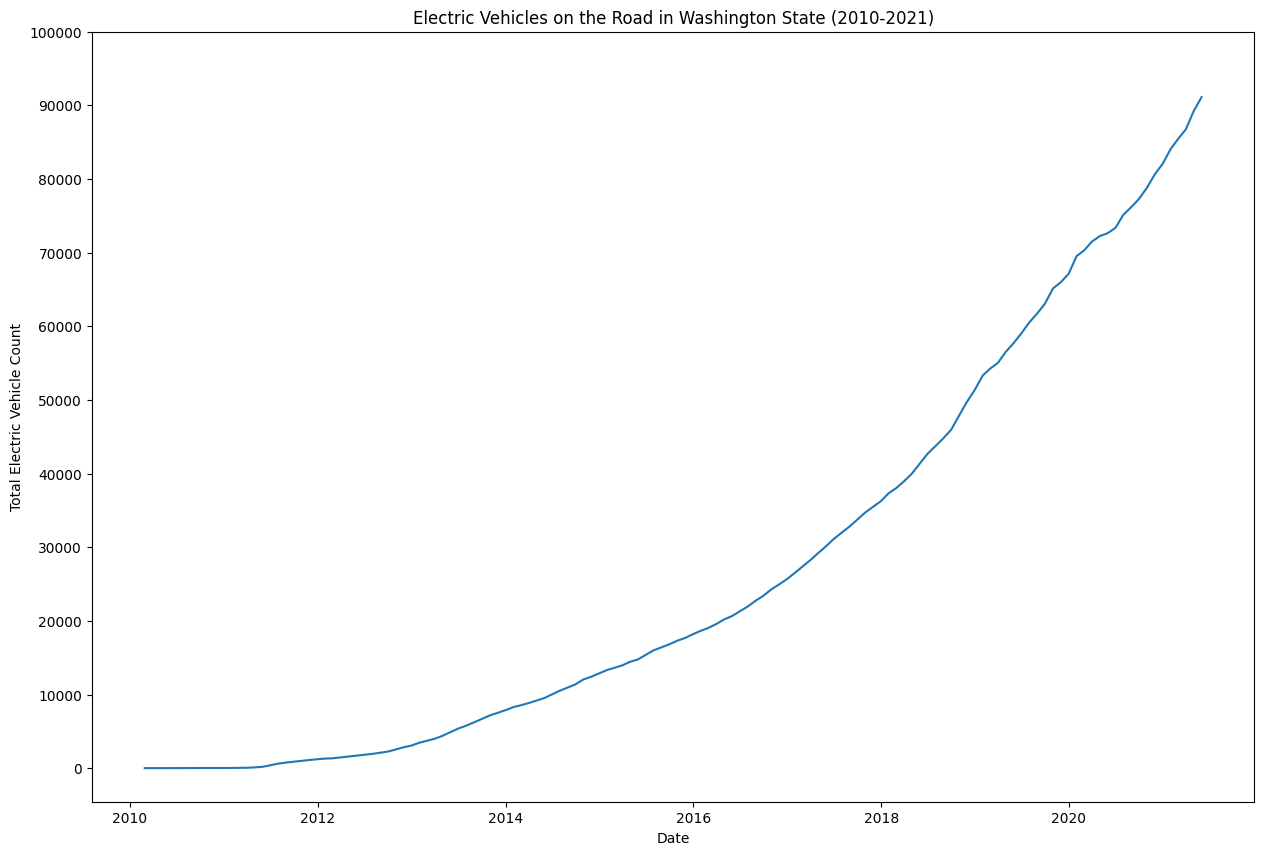

In [371]:
#plotting statewide EV Count
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='transaction_date', y='State Total', data=df_cumsum, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Total Electric Vehicle Count')
ax.set_title('Electric Vehicles on the Road in Washington State (2010-2021)')
ax.set_yticks(range(0,110000,10000))


As we can see above, the amount of electric vehicles on Washington State roads have been increasing exponentially over the past 10 years. On a high level, this confirms that Washington State has the necessary demand trend for electric vehicles to make investing in it profitable for an EV charging company. 

Since our data goes back as far as 2010, the count starts with 0 in 2010. However, it is important to note that this does not necessarily mean that there weren't any electric vehicles on the road in 2010. We are simply taking 2010 as our starting point and therefore the counts are relative.

## Electric Vehicles on the Road Over Time by County

Now that we looked at the statewide trend, we can start looking at individual counties. Since we have limited time for this analysis, we will be limiting our analysis to the top 10 counties that had the most electric vehicle purchases in the past 10 years.

In [372]:
df['county'].value_counts()

county
King            62119
Snohomish       12305
Pierce           8949
Clark            6155
Thurston         4110
Kitsap           4104
Whatcom          2963
Spokane          2575
Benton           1277
Island           1251
Skagit           1204
Clallam           708
Jefferson         692
San Juan          663
Cowlitz           537
Chelan            521
Mason             520
Yakima            508
Lewis             437
Grays Harbor      396
Franklin          347
Grant             267
Walla Walla       256
Kittitas          247
Douglas           190
Whitman           159
Klickitat         153
Pacific           136
Stevens           125
Okanogan          104
Skamania          100
Asotin             49
Adams              30
Pend Oreille       28
Wahkiakum          28
Lincoln            25
Ferry              16
Columbia           13
Garfield            2
Name: count, dtype: int64

In [373]:
top_ten_counties = ['King', 'Snohomish', 'Pierce', 'Clark', 'Thurston', 
                  'Kitsap', 'Whatcom', 'Spokane', 'Benton', 'Island']

In [374]:
#filtering out counties to keep top 10
df_cumsum = df_cumsum.loc[:, ['transaction_date', *top_ten_counties]]
df_cumsum.head()

,transaction_date,King,Snohomish,Pierce,Clark,Thurston,Kitsap,Whatcom,Spokane,Benton,Island
0,2010-02-28,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,2010-03-31,1.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0
2,2010-04-30,2.0,0.0,0.0,1.0,0.0,1,1.0,1.0,0.0,0.0
3,2010-05-31,2.0,1.0,0.0,1.0,1.0,1,1.0,1.0,0.0,0.0
4,2010-06-30,3.0,1.0,0.0,1.0,1.0,1,1.0,1.0,0.0,0.0


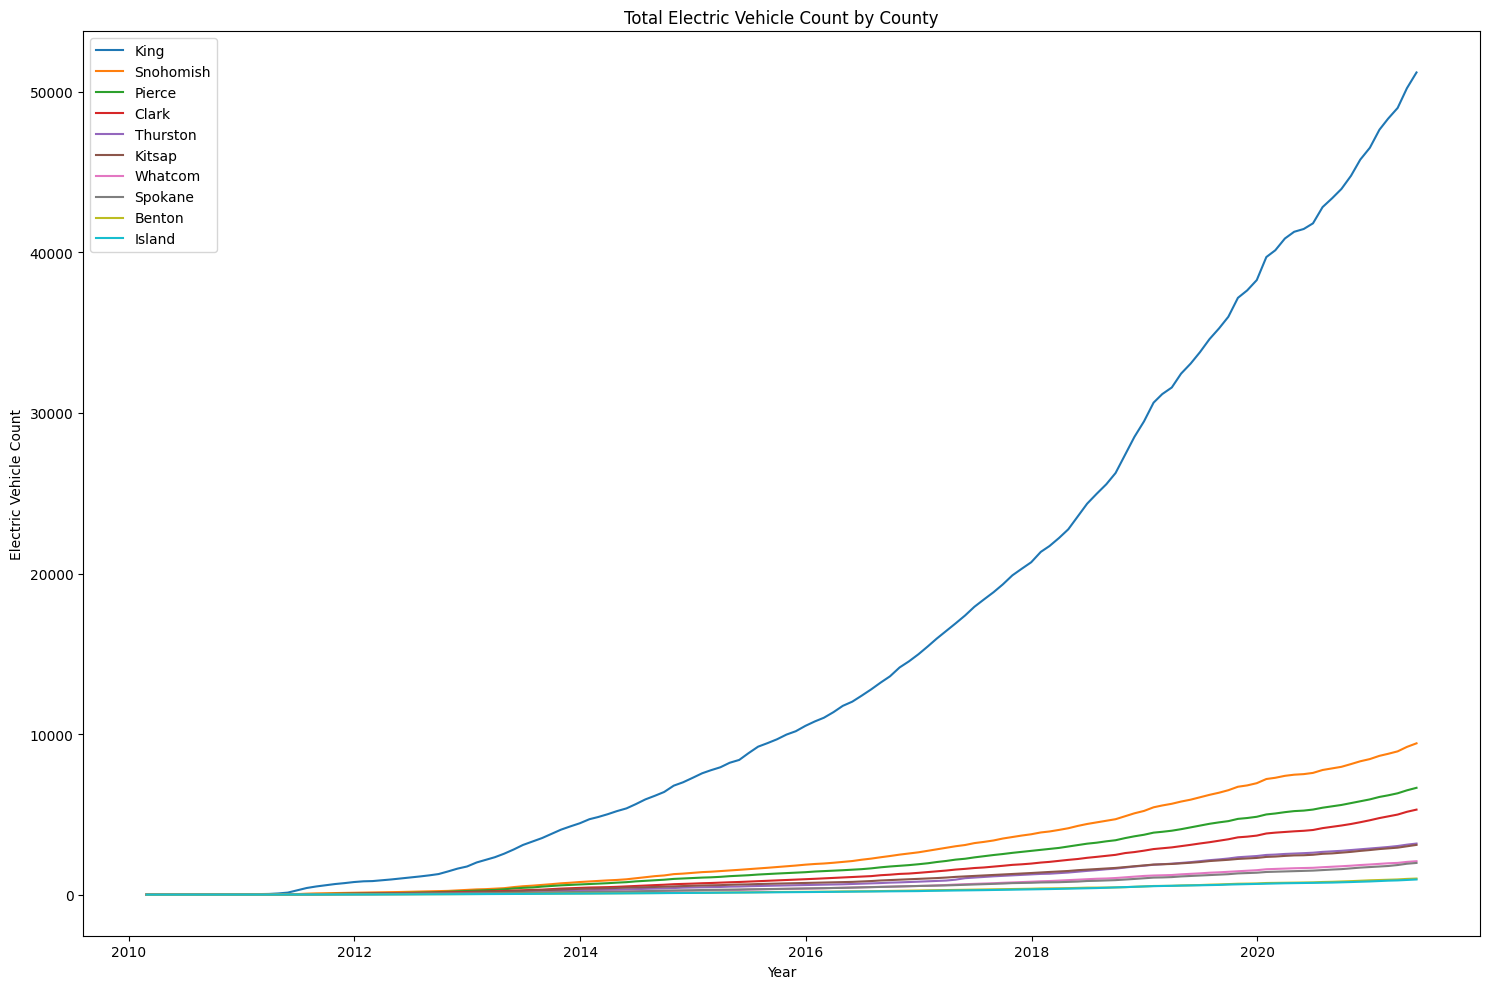

In [375]:
#plotting county trends
fig, ax = plt.subplots(figsize=(15,10))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax, 
                 label=county)
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Count')
ax.set_title('Total Electric Vehicle Count by County')
ax.legend()
# df_cumsum.plot()
plt.tight_layout();
plt.savefig('images/output_110_0.png', facecolor='white')

Here, we can see that out of the top 10 most EV purchasing counties, King County has been growing much faster compared to others. This is expected since King County includes Seattle, which is the largest city by population in Washington State. Due to the scale differences between King County and the other 9 counties, it is difficult to see how these 9 counties compare to each other.

## Electric Vehicles on the Road Over Time (Excluding King County)

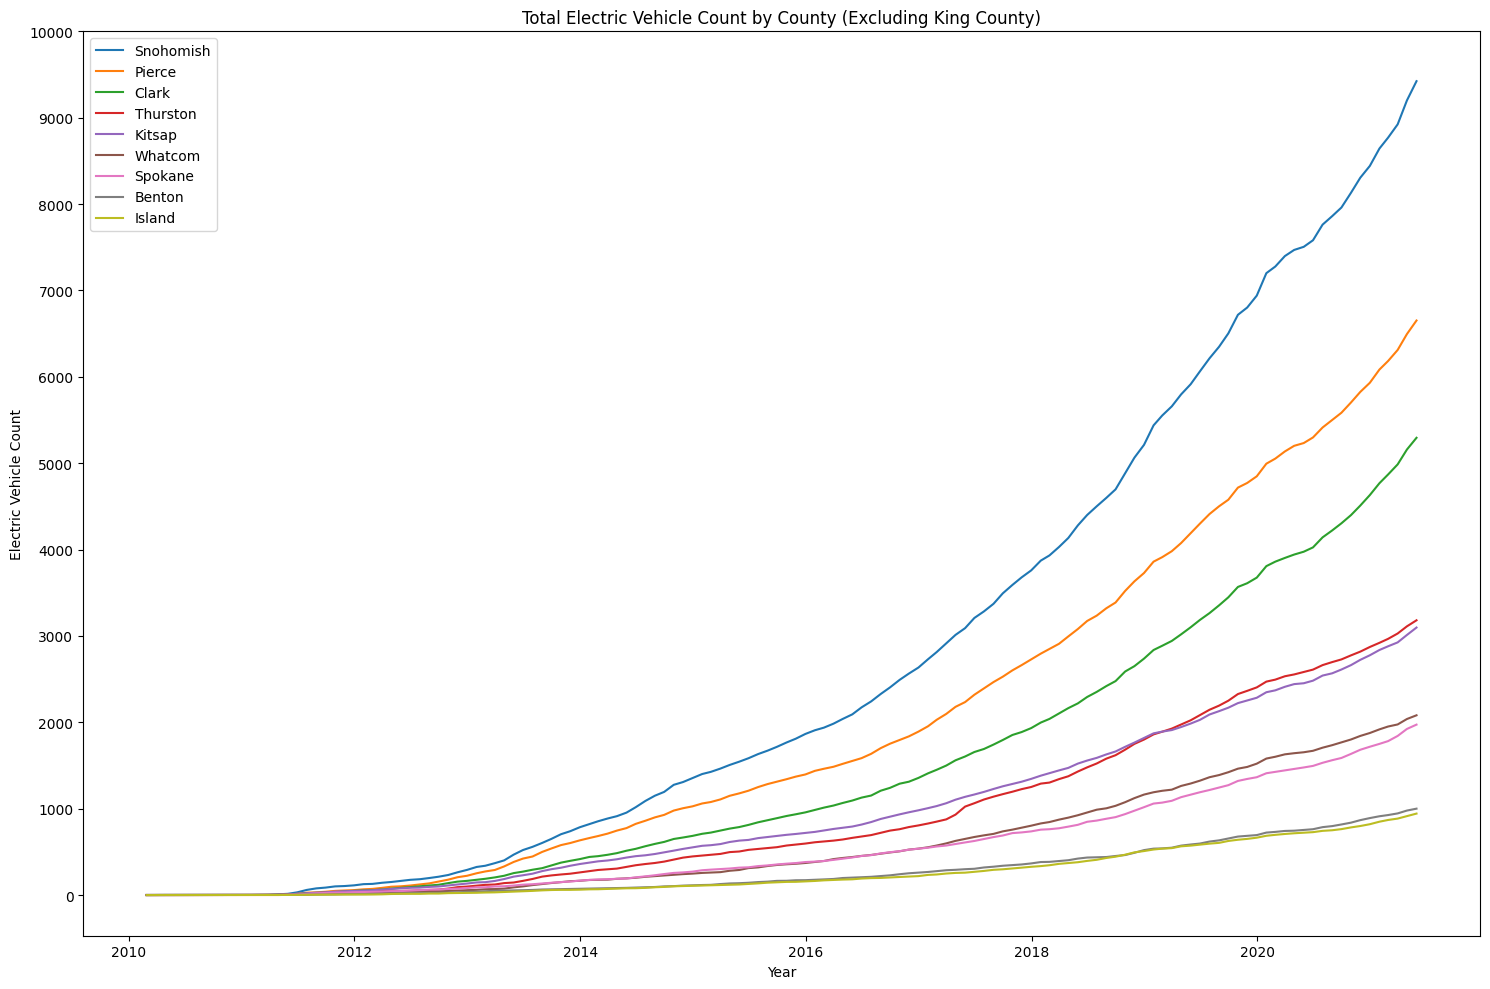

In [376]:
#plotting county trends except for King County
top_ten_counties.remove('King')

fig, ax = plt.subplots(figsize=(15,10))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax, 
                 label=county)
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Count')
ax.set_title('Total Electric Vehicle Count by County (Excluding King County)')
ax.set_yticks(range(0,11000,1000))
ax.legend()
plt.tight_layout();
plt.savefig('images/output_113_1.png', facecolor='white')

When we exclude King County, we can see that Snohomish County is leading the charge in electric vehicle purchases followed by Pierce and Clark County. 

In [377]:
top_ten_counties += ['King']

## Most Purchased Car Models by County

Another important piece of information that can be relevant for an electric charging company is what the most purchased electric vehicle models are in each of these counties to decide on additional factors. These may include: 

- Whether to include adapters for different connector types (Tesla, CCS, CHAdeMO etc.)
- What kind of charging station to build (level 1, level 2, level 3)
- Spacing of chargers based on the size of vehicles

In [378]:
def model_counts_by_county(df=df, top_n=10, county_list=top_ten_counties):
    
    """Function plots top n most purchased models as a bar plot for each of 
    the counties provided.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame, default: df
    Dataframe containing title transactions for all counties.
    
    top_n: int, default: 10
    Number of most purchased models to plot.
    
    county_list: list, default: top_ten_counties
    The counties that will be analyzed.
    """
    
    fig, ax = plt.subplots(figsize=(10, 60), nrows=len(county_list))
    
    for i, county in enumerate(county_list):
        df_county = df[(df['county']==county) & 
                       (df['transaction_type']=='Original Title')]
        model_count_df = pd.DataFrame(df_county['model'].value_counts()).reset_index()
        model_count_df.columns=['model', 'count']
        sns.barplot(x='model', y='count', data=model_count_df.head(top_n), 
                    ax=ax[i])
        ax[i].set_title(f'Top {top_n} Most Purchased Models in {county} County (2010-2021)')
    plt.tight_layout();

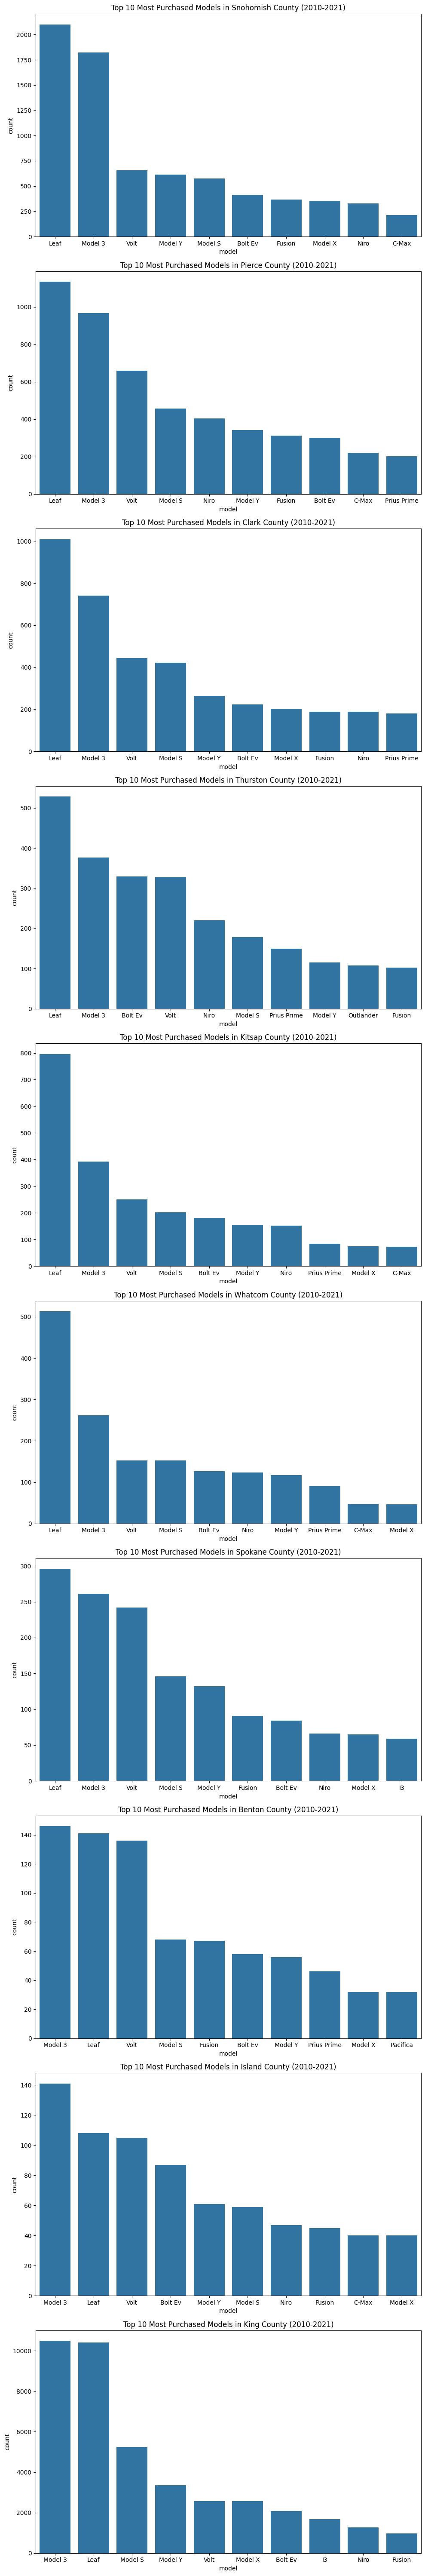

In [379]:
model_counts_by_county()
plt.savefig('images/output_119_0.png', facecolor='white')

Nissan Leaf and Tesla Model 3 are the most purchased vehicles in each of these counties. Nissan Leaf was released in December 2010 and is widely considered to be the first mass-market electric vehicle. Tesla's Model 3 is a relatively lower priced luxury electric vehicle that was designed to appeal to the mass market as well. Considering these factors, it is not surprising that these vehicles are the most purchased vehicles in each county.

# MODEL

## Preprocessing/ Defining Functions

In [380]:
df_cumsum = df_cumsum.set_index('transaction_date').resample('M').asfreq()

In [381]:
df_cumsum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2010-02-28 to 2021-05-31
Freq: M
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   King       136 non-null    float64
 1   Snohomish  136 non-null    float64
 2   Pierce     136 non-null    float64
 3   Clark      136 non-null    float64
 4   Thurston   136 non-null    float64
 5   Kitsap     136 non-null    int64  
 6   Whatcom    136 non-null    float64
 7   Spokane    136 non-null    float64
 8   Benton     136 non-null    float64
 9   Island     136 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 11.7 KB


### Separating Data for Each County

As discussed above, we will be creating time series models for the top ten counties. This requires us to break down the dataframe we have into smaller dataframes for each county.

In [382]:
def separate_data_by_county(county, df):
    """Function separates the given dataframe by county and returns the 
    separated dataframe.
    -------------------------------
    Arguments:
    county: str
    Name of county that will be separated from the dataframe. 
    
    df: class: pandas.DataFrame
    Dataframe that contains data for all counties. The specified county will 
    be separated from this DataFrame. 
    """
    
    df_county = pd.DataFrame(df.loc[:, county])
    df_county.columns=["EV's on the Road"]
    df_county.head()
    return df_county

In [383]:
#separating data by county and parsing this information to a dictionary
county_information = {}
for county in top_ten_counties:
    county_information[county] = {}
    county_information[county]['df']=separate_data_by_county(county, df_cumsum)

In [384]:
#separating data by county and parsing this information to a dictionary
county_dfs = {}
for county in top_ten_counties:
    county_dfs[county] = separate_data_by_county(county, df_cumsum)

### Functionizing the Evaluation of Models

Before modelling, one of the functions we will need is a function that will show us the various statistics so that we can evaluate the performance of the model.

In [385]:
def evaluate_model(model):
    """Function returns the model summary and diagnostics information to aid 
    the evaluation of the given model's performance.
    -------------------------------
    Arguments:
    model: SARIMAX or ARIMA model object
    Model variable to evaluate (Time series models for both pmdarima and 
    statsmodels are supported. 
    """
    
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout();

### Creating a Function for train_test_split & plotting

We will be splitting the time series into two: a training set and a testing set. This will allow us to validate the performance of the models.

In [386]:
def train_test_split_ts (df, train_size, test_size):
    
    """Function splits a given DataFrame into two sets based on the given 
    train and test sizes so that the data can be used for validation.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame
    The base dataframe that will be getting split.
    
    train_size: float
    The size of the desired training set (for example: 0.80)
    
    test_size: float
    The size of the desired training set (for example: 0.20)
    """
    
    train_end_idx = int(round(len(df)*train_size,0))
    train_set = df.iloc[0:train_end_idx,:]["EV's on the Road"]
    test_set = df.iloc[train_end_idx:,:]["EV's on the Road"]
    return train_set, test_set

Additionally, to visualize these splits we will need a plotting function.

In [387]:
def plot_train_test_split(train_data, test_data, county):
    
    """Function plots the training and testing data for visual inspection.
    -------------------------------
    Arguments:
    train_data: pandas.Series
    The training set of data to be plotted.
    
    test_data: pandas.Series
    The test set of data to be plotted.
    
    county: str
    Name of the county that the training and testing data belongs to. This 
    string is used to set the title of the axes.
    """
    
    train_data.plot(label='Train Data')
    test_data.plot(label='Test Data')
    ax=plt.gca()
    ax.set_xlabel('Year')
    ax.set_ylabel('Electric Vehicles on the Road')
    ax.set_title(f'Electric Vehicles on the Road in {county} County')
    ax.legend();

### Creating a Function for Getting Forecasts

For validation purposes we will be getting the forecast from our model for the test period and will be plotting it against the actual test data.

In [388]:
def get_forecast(model, train_data, test_data, plot=True):
    
    """Function gets forecasted values from a given model and plots them for 
    visual inspection. The length of the forecasts are dependent on the length 
    of the test data. The forecasted values are returned in a DataFrame format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model that the forecast is to be received from. 
    
    train_data: pandas.Series
    The training set of data used in training the model.
    
    test_data: pandas.Series
    The testing set of data used for validating the model.
    
    plot: bool, default=True
    Option to plot the forecasted values along with observed values 
    (train_data and test_data).
    """
    
    #creating a df with the forecast information
    forecast_df = model.get_forecast(steps=len(test_data)).conf_int()
    forecast_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    forecast_df['Forecasts'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('default'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=train_data, color='black', ax=ax)
            sns.lineplot(data=forecast_df, x=forecast_df.index, 
                         y='Forecasts', color='blue', ax=ax, 
                         label='Forecasted Data', ls='--')
            sns.lineplot(data=test_data, color='purple', ax=ax, 
                         label='Actual Data', ls='-.')
            ax.fill_between(forecast_df.index, 
                            y1=forecast_df['Lower Confidence Interval'], 
                            y2=forecast_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.legend(loc=2)
            plt.show();
    return forecast_df

### Defining a Function for Getting Predictions for Future

Lastly, we will also be needing a function similar to the get_forecast function that will be used for getting predictions for the future and plotting for visualization.

In [389]:
def get_prediction(model, df, test_data, county_name, plot=True):
    
    """Function gets predicted values from a given model and plots them for 
    visual inspection. The length of the predictions are dependent on the 
    length of the test data. The forecasted values are returned in a DataFrame 
    format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model to be used for making predictions.
    
    df: pandas.DataFrame
    DataFrame that contains all observed data.
    
    test_data: pandas.Series
    The testing set of data used for validating the model (dictates the length
    of predictions).
    
    plot: bool, default=True
    Option to plot the predicted values along with observed values.
    """
    
    #creating a df with the prediction information
    prediction_df = model.get_forecast(steps=len(test_data)).conf_int()
    prediction_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    prediction_df['Predictions'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('default'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=df, ax=ax)
            sns.lineplot(data=prediction_df, x=prediction_df.index, 
                         y='Predictions', color='orange', ax=ax, 
                         label='Predicted Data', ls='--')
            ax.fill_between(prediction_df.index, 
                            y1=prediction_df['Lower Confidence Interval'], 
                            y2=prediction_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.set_ylabel('Electric Vehicles on the Road')
            ax.set_title(f'Predicted Electric Vehicle Count for {county_name}')
            plt.show();
    return prediction_df

## King County

### Seasonality Check

Prior to starting modeling, it is important to decompose the data to get a better sense of the trend and seasonality components of it.

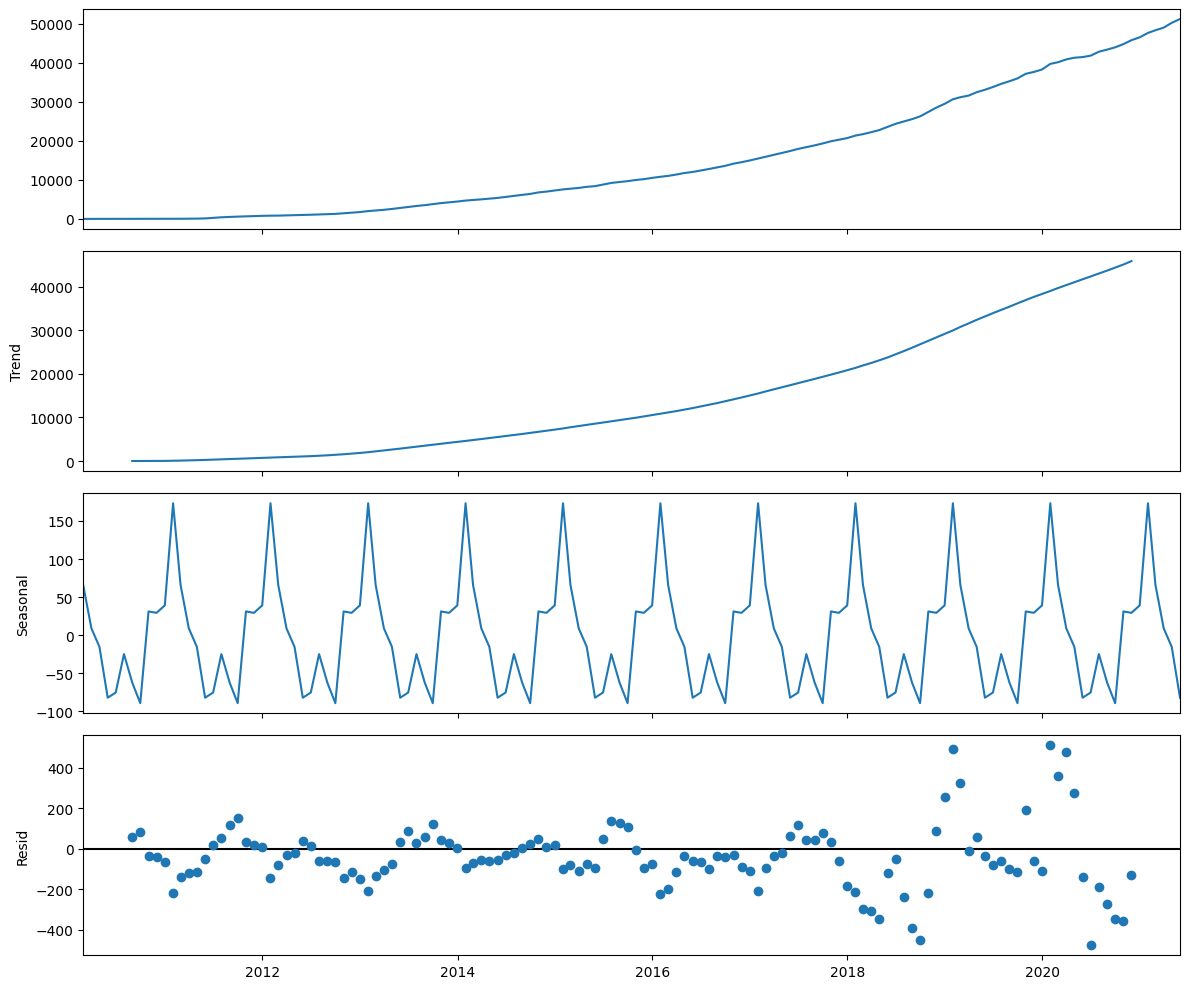

In [390]:
import statsmodels.tsa.api as tsa

plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['King']['df'])
decomp.plot();

Not surprisingly, the electric vehicle count for King County has an upward trend. Additionally, we can see that there is seasonality to the data as well. We can now move onto creating the training and testing sets for validation.

### train_test_split

After multiple iterations, we found that the 0.80-0.20 split of the data belonging to King County resulted in the best performance.

In [391]:
#splitting dataset into train and test sets for validation
train_king, test_king = train_test_split_ts(county_information['King']['df'], 
                                            0.80, 0.20)

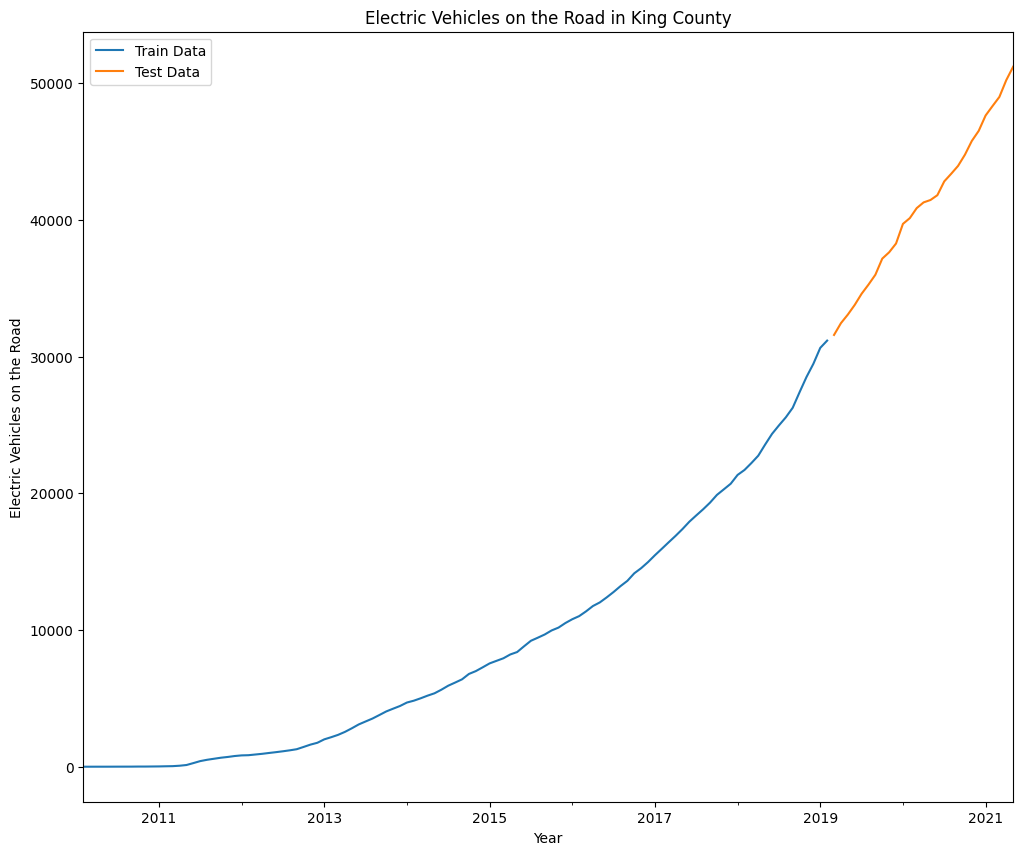

In [392]:
#plotting the split
plot_train_test_split(train_king, test_king, 'King')

### Finding Best Parameters with Auto-Arima

To have a model that can accurately predict future values, we need to optimize the p,d,q values of the models for each county and validate. In order to achieve this programmatically, we will be using the pmdarima library.

In [393]:
import pmdarima as pm

In [394]:
auto_model = pm.auto_arima(train_king, start_p=0, d=1, start_q=0, max_p=4, 
                           max_d=3, max_q=4, start_P=0, start_Q=0, max_P=3, 
                           max_D=3, max_Q=3, m=12)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -570.311
Date:                            Wed, 08 May 2024   AIC                           1146.622
Time:                                    18:10:41   BIC                           1154.315
Sample:                                02-28-2010   HQIC                          1149.732
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.5075     13.389      1.980      0.048       0.265      52.750
ar.L1          0.7305      0.051     14.288      0.000       0.630       0.831
sigma2      8406.5771    814.661     10.319      0.000    6809.871       1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                61.47
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               7.72   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Validate Model with Forecasts for Test Data

In [395]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -567.043
Date:                            Wed, 08 May 2024   AIC                           1138.087
Time:                                    18:10:41   BIC                           1143.195
Sample:                                02-28-2010   HQIC                          1140.151
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8305      0.042     20.002      0.000       0.749       0.912
sigma2      8954.2159    822.909     10.881      0.000    7341.344    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                42.89
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               7.52   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

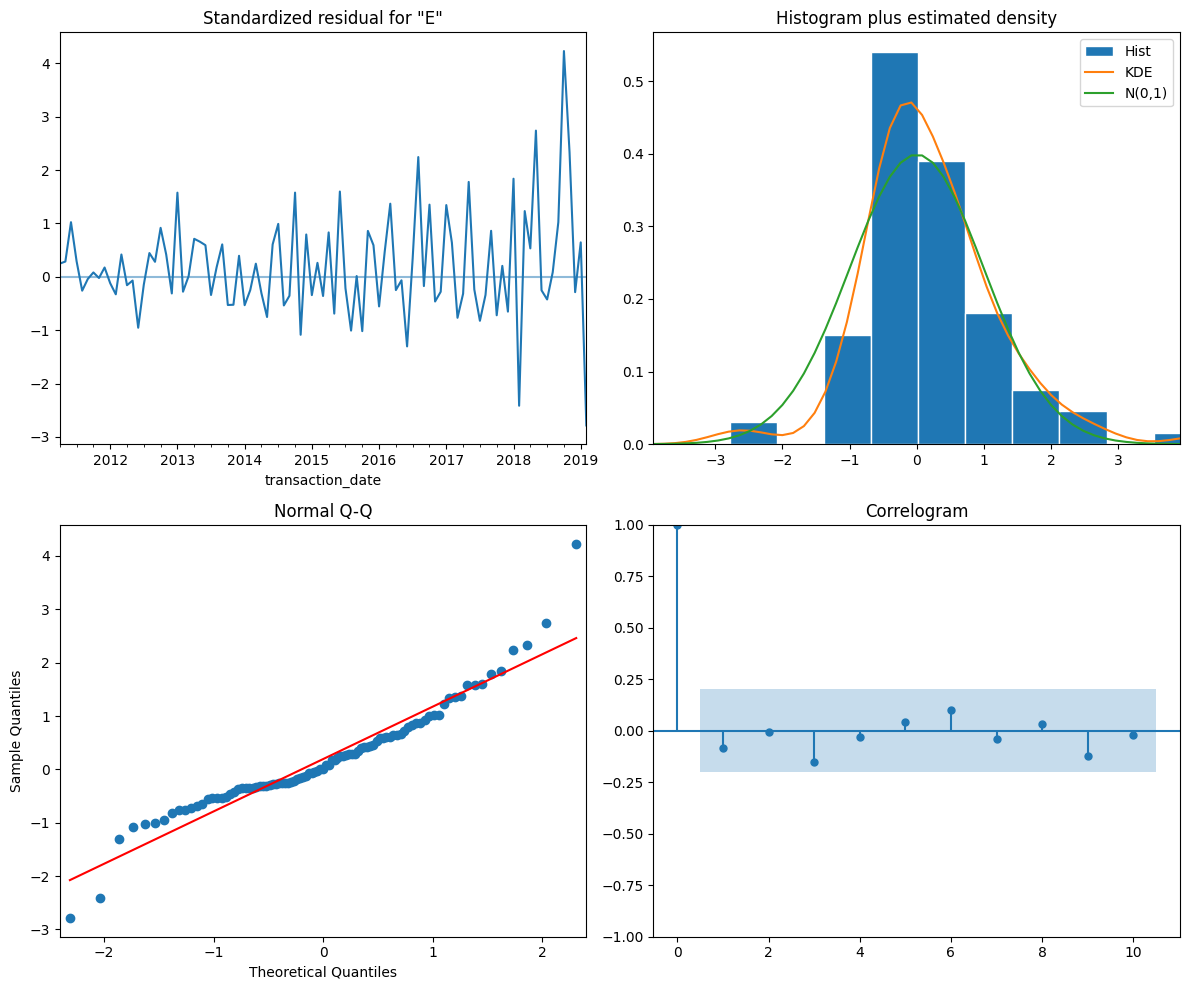

In [396]:
model = SARIMAX(train_king, order=(1,1,0), 
                seasonal_order=(0,1,0,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

Here, looking at the residual information, we can see that they are very close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant. These results suggest that the model is satisfactory to move onto validation.

Above, we can see that the model is able to accurately forecast data into the future. The actual observed data is well within the confidence interval of our model's forecasts.

### Future Predictions

#### Fitting Model to All Observed Data

Now that we know that our model can accurately make predictions about the future electric vehicle counts in each county, we can use the same parameters to build a model on the whole observed dataset without splitting it into train/test sets.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -818.139
Date:                            Wed, 08 May 2024   AIC                           1640.277
Time:                                    18:10:42   BIC                           1645.885
Sample:                                02-28-2010   HQIC                          1642.555
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4919      0.062      7.989      0.000       0.371       0.613
sigma2      3.911e+04   2910.227     13.440      0.000    3.34e+04    4.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):               108.03
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              26.48   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

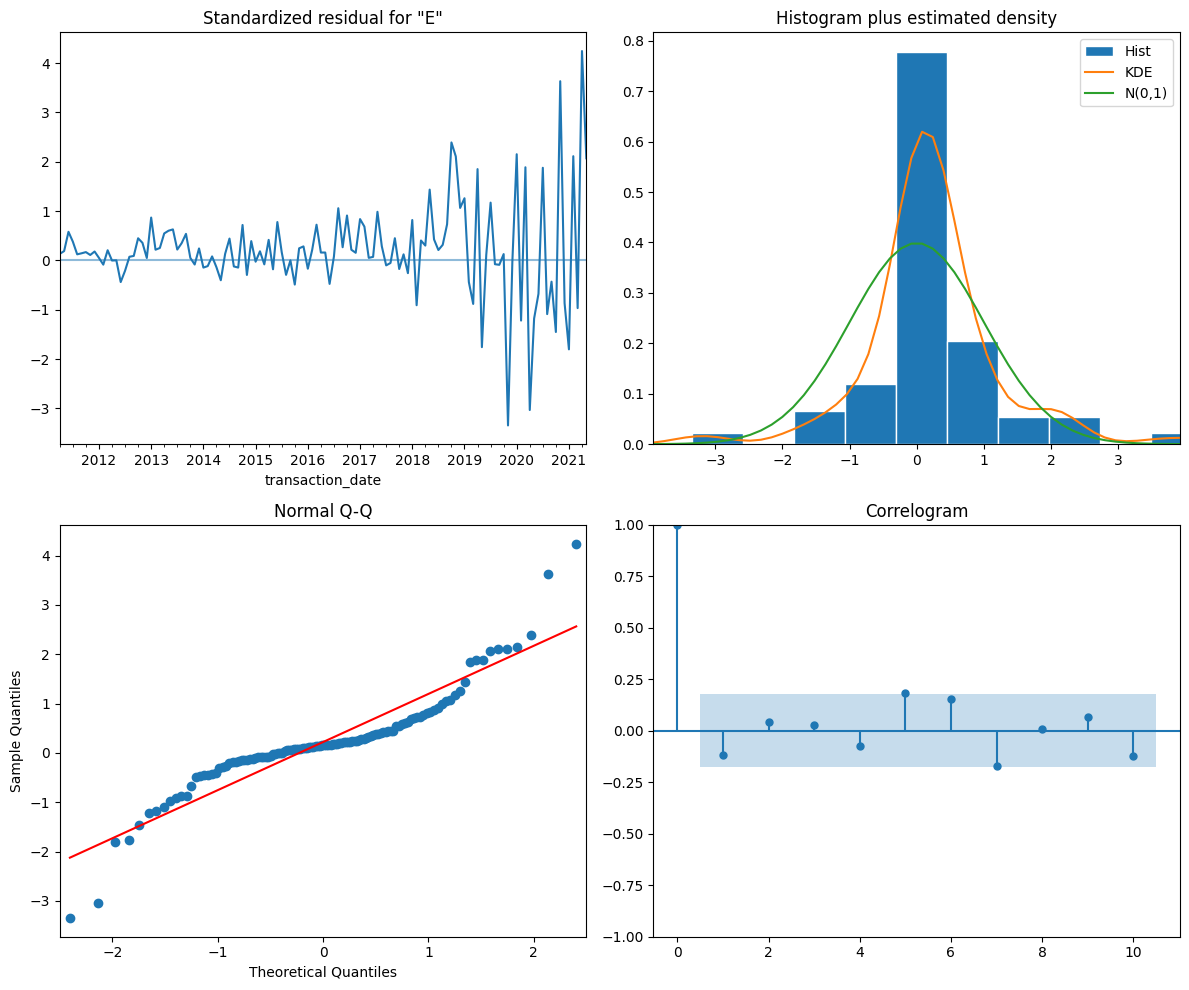

In [397]:
model = SARIMAX(county_information['King']['df'], order=(1,1,0), 
                seasonal_order=(0,1,0,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

Above we can see that the residuals for this model are less normally distributed compared to the test model. However, they are still fairly close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant.

#### Plotting & Saving Predictions

Using our model, we can predict the future counts of electric vehicles in King County and plot them. 

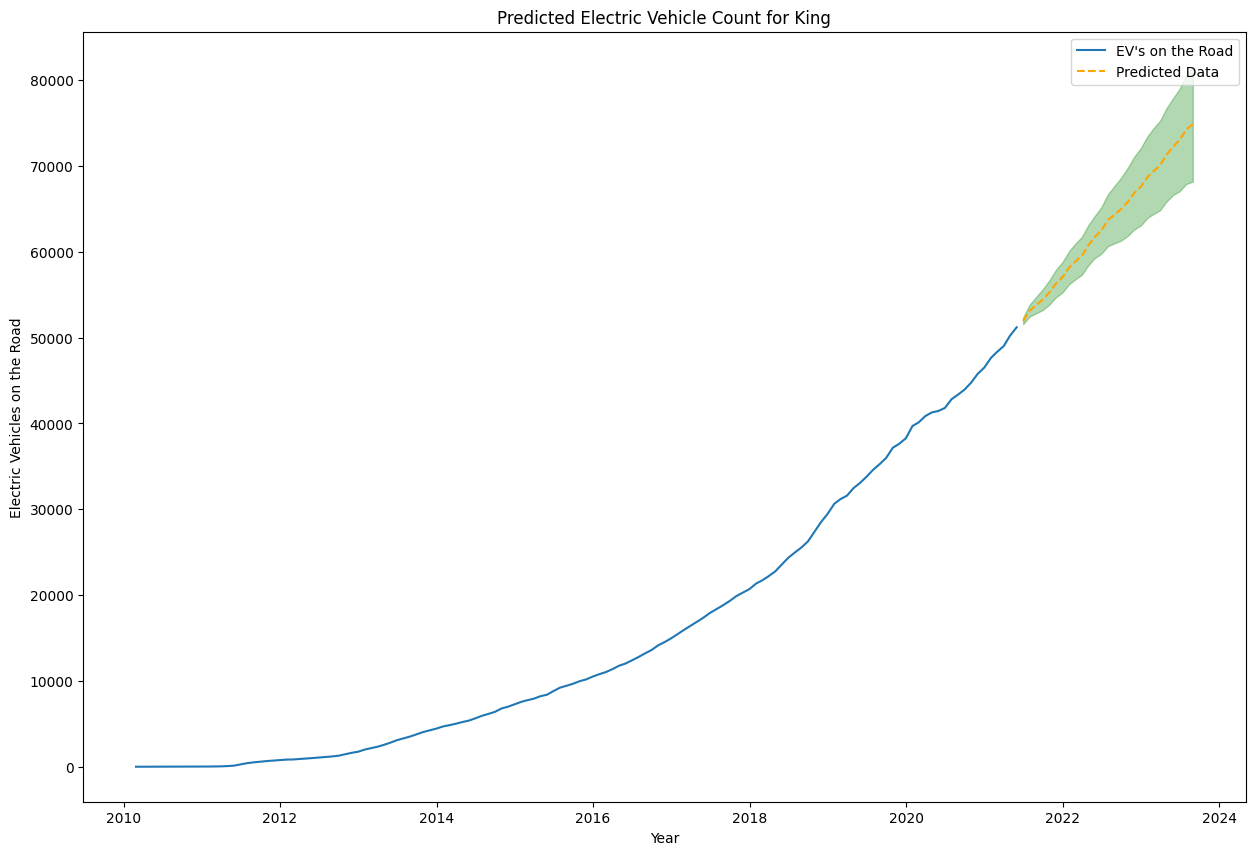

In [398]:
#creating a df of predictions and plotting
df_king_preds = get_prediction(model, county_information['King']['df'], 
                               test_king, 'King', plot=True)

The model is predicting that the amount of electric vehicles in King County are going to keep increasing almost linearly based on the mean values. If we look at the upper confidence interval though, we can see that the increase could keep an exponential pattern.